## Outlier Engineering


An outlier is a data point which is significantly different from the remaining data. “An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism.” [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980].

Statistics such as the mean and variance are very susceptible to outliers. In addition, **some Machine Learning models are sensitive to outliers** which may decrease their performance. Thus, depending on which algorithm we wish to train, we often remove outliers from our variables.

We discussed in section 3 of this course how to identify outliers. In this section, we we discuss how we can process them to train our machine learning models.


## How can we pre-process outliers?

- Trimming: remove the outliers from our dataset
- Treat outliers as missing data, and proceed with any missing data imputation technique
- Discrestisation: outliers are placed in border bins together with higher or lower values of the distribution
- Censoring: capping the variable distribution at a max and / or minimum value

**Censoring** is also known as:

- top and bottom coding
- winsorization
- capping


## Trimming or truncation

Trimming, also known as truncation, involves removing the outliers from the dataset. We only need to decide on a metric to determine outliers. As we saw in section 3, this can be the Gaussian approximation for normally distributed variables or the inter-quantile range proximity rule for skewed variables.

### Advantages

- quick

### Limitations

- outliers for one variable could contain useful information in the other variables
- if there are outliers across many variables, we could remove a big chunk of dataset

## In this Demo

We will see how to perform trimming 

## Important

Outliers should be detected AND **removed ONLY** from the training set, and NOT from the test set.

So we should first divide our data set into train and tests, and remove outliers in the train set, but keep those in the test set, and measure how well our model is doing.

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# for Q-Q plots
import scipy.stats as stats

from sklearn.model_selection import train_test_split

In [2]:
data_raw = pd.read_csv('C://Users/gusal/machine learning/Feature engineering/loan_reduced.csv')

In [3]:
data_raw.head()

,loan_status,total_pymnt,total_pymnt_inv
0,Current,167.02,167.02
1,Current,1507.11,1507.11
2,Current,353.89,353.89
3,Current,286.71,286.71
4,Current,1423.21,1423.21


In [4]:
data_raw['loan_status'].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

## We need to map 'loan_status'

In [5]:
# first let's create a dictionary with the mappings of categories to numbers

ordinal_mapping = {
    k: i
    for i, k in enumerate(data_raw['loan_status'].unique(), 0)
}

ordinal_mapping

{'Current': 0,
 'Fully Paid': 1,
 'Late (31-120 days)': 2,
 'In Grace Period': 3,
 'Charged Off': 4,
 'Late (16-30 days)': 5,
 'Default': 6,
 'Does not meet the credit policy. Status:Fully Paid': 7,
 'Does not meet the credit policy. Status:Charged Off': 8}

The dictionary indicates which number will replace each category. Numbers were assigned arbitrarily from 0 to n - 1 where n is the number of distinct categories.

In [6]:
# replace the labels with the integers

data_raw['loan_status'] = data_raw['loan_status'].map(ordinal_mapping)


In [7]:
data_raw.head()

,loan_status,total_pymnt,total_pymnt_inv
0,0,167.02,167.02
1,0,1507.11,1507.11
2,0,353.89,353.89
3,0,286.71,286.71
4,0,1423.21,1423.21


In [31]:
data_raw.shape

(2260663, 3)

In [8]:
data_raw['loan_status'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [14]:
# function to create histogram, Q-Q plot and
# boxplot. We learned this in section 3 of the course


def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

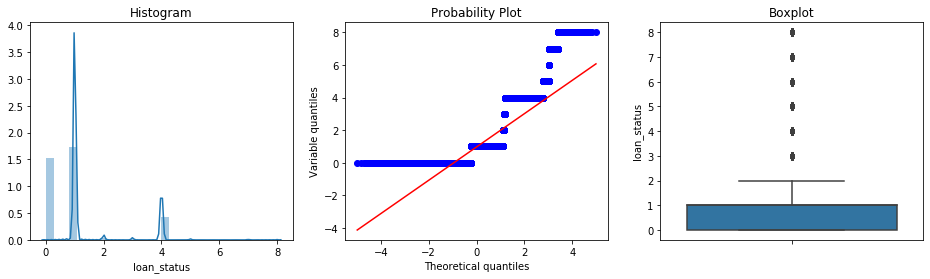

In [15]:
# let's find outliers in loan_status

diagnostic_plots(data_raw, 'loan_status')

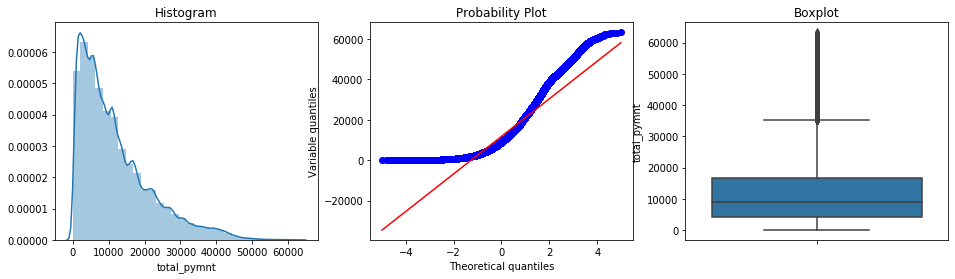

In [16]:
# let's find outliers in total_pymnt

diagnostic_plots(data_raw, 'total_pymnt')

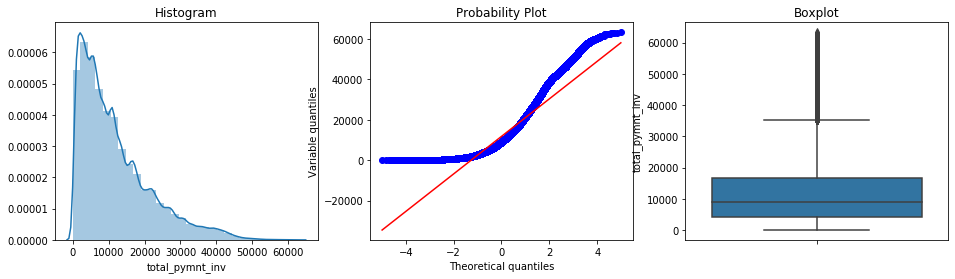

In [17]:
# let's find outliers in total_pymnt_inv

diagnostic_plots(data_raw, 'total_pymnt_inv')

There are outliers in all of the above variables. All variables show outliers only on the right tail.

Let's find the outliers

In [18]:
def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [22]:
# find limits for loan_status

loan_status_upper_limit, loan_status_lower_limit = find_skewed_boundaries(data_raw, 'loan_status', 1.5)
loan_status_upper_limit, loan_status_lower_limit

(2.5, -1.5)

In [23]:
# find limits for total_pymnt

total_pymnt_upper_limit, total_pymnt_lower_limit = find_skewed_boundaries(data_raw, 'total_pymnt', 1.5)
total_pymnt_upper_limit, total_pymnt_lower_limit

(35361.09822085014, -14380.53093251008)

In [25]:
# find limits for total_pymnt

total_pymnt_inv_upper_limit, total_pymnt_inv_lower_limit = find_skewed_boundaries(data_raw, 'total_pymnt_inv', 1.5)
total_pymnt_inv_upper_limit, total_pymnt_inv_lower_limit

(35319.822499999995, -14379.477499999999)

In [27]:
# let's flag the outliers in the data set

outliers_loan_status = np.where(data_raw['loan_status'] > loan_status_upper_limit, True,
                       np.where(data_raw['loan_status'] < loan_status_lower_limit, True, False))

In [28]:
# let's flag the outliers in the data set

outliers_total_pymnt = np.where(data_raw['total_pymnt'] > total_pymnt_upper_limit, True,
                       np.where(data_raw['total_pymnt'] < total_pymnt_lower_limit, True, False))

In [29]:
# let's flag the outliers in the data set

outliers_total_pymnt_inv = np.where(data_raw['total_pymnt_inv'] > total_pymnt_inv_upper_limit, True,
                       np.where(data_raw['total_pymnt_inv'] < total_pymnt_inv_lower_limit, True, False))

In [30]:
# let's trimm the dataset

data_raw_trimmed = data_raw.loc[~(outliers_loan_status + outliers_total_pymnt + outliers_total_pymnt_inv), ]

data_raw.shape, data_raw_trimmed.shape

((2260663, 3), (1902103, 3))

We can see that using trimming, we removed (2260663 - 1902103 ) 358560 rows, from a dataset of 2260663 rows, this is about 16% of the data was removed. This is mostly why, we do not tend to use trimming much in machine learning. But if only a few variables present a tiny proportion of outliers, trimming could work.

In [33]:
# calculating percentage of data trimmed
(2260663 - 1902103)/2260663

0.1586083374656019

In [37]:
data_raw_trimmed.head()

,loan_status,total_pymnt,total_pymnt_inv
0,0,167.02,167.02
1,0,1507.11,1507.11
2,0,353.89,353.89
3,0,286.71,286.71
4,0,1423.21,1423.21


In [40]:
data_raw_trimmed.loan_status.unique()

array([0, 1, 2], dtype=int64)

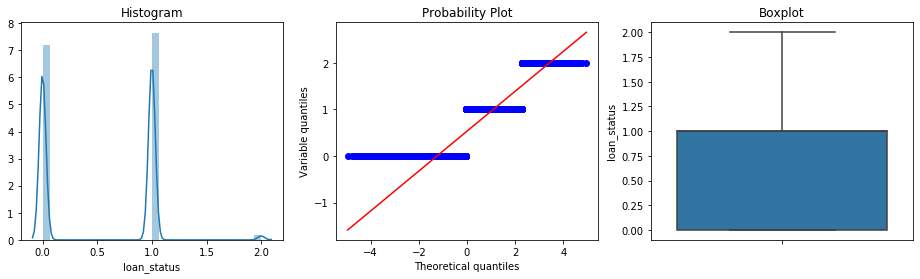

In [34]:
# let's explore outliers in the trimmed dataset
# for RM we see much less outliers as in the original dataset

diagnostic_plots(data_raw_trimmed, 'loan_status')

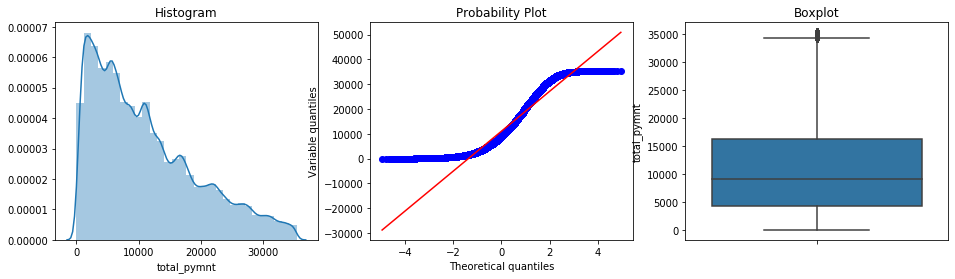

In [35]:
# let's explore outliers in the trimmed dataset
# for RM we see much less outliers as in the original dataset

diagnostic_plots(data_raw_trimmed, 'total_pymnt')

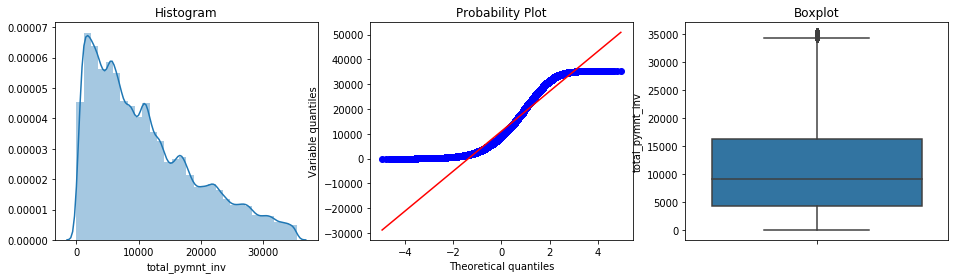

In [36]:
# let's explore outliers in the trimmed dataset
# for RM we see much less outliers as in the original dataset

diagnostic_plots(data_raw_trimmed, 'total_pymnt_inv')

For total_pymnt and total_pymnt_inv, we still see many outliers. When we remove data points from our dataset, all the parameters of the distribution are re-calculated, those are the mean, quantiles and inter-quantile range, therefore, in the new -trimmed- variable, values that before were not considered outliers, now are.

This is an unwanted characteristic of this way of coping with outliers.